# 概要

Character-LevelのCNNでWAFを作る。  
論文の内容をKerasで実装してみる。  
原著論文はこちら http://iyatomi-lab.info/sites/default/files/user/CSPA2018%20Proceedings_ito.pdf 


## データの準備

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPool1D
from keras.layers import Add, Reshape, normalization, Concatenate
from keras.utils import plot_model, to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import backend as K

In [3]:
%cd /content/drive/MyDrive/WAffle/
!ls -al

/content/drive/MyDrive/WAffle
total 379
-rw------- 1 root root    151 Dec 18 14:37 2020-12-18.gslides
-rw------- 1 root root 225943 Jan  3 14:29 CharacterLevel-CNN
drwx------ 2 root root   4096 Dec 27 18:45 Dataset
drwx------ 2 root root   4096 Dec 27 13:42 KerasPractice
drwx------ 2 root root   4096 Dec 30 12:35 model_dir
-rw------- 1 root root 148218 Jan  3 14:28 model.png
-rw------- 1 root root    151 Oct 26 12:09 WAF_Overview_補足資料.gslides


In [4]:
df = pd.read_csv('Dataset/cisc_database/csic_database.csv')

In [5]:
df = df.rename(columns={'Unnamed: 0':'Target'})

In [6]:
# Targetカラムの変更。
# if (df['Target'] == Normal){0} else {1}

df['Target'] = df['Target'].apply(lambda x:0 if str(x) == 'Normal' else 1)
df.head()

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


### 前処理

目標: 'Target', 'URL'のみをInputとして与える。


In [7]:
X, y = df.iloc[:, 16].values, df.iloc[:, 0].values

In [8]:
X_train, X_test,y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [9]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (48852,)
y_train shape (48852,)
X_test shape (12213,)
y_test shape (12213,)


In [10]:
# convert string to lower case
# 後回し

#X_train = [s.lower() for s in X_train]
#X_test = [s.lower() for s in X_test]

In [11]:
# convert string to index
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
string_size = len(alphabet)

In [12]:
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
#tk.fit_on_texts(X_train_texts)

In [13]:
print(X_train)

['http://localhost:8080/tienda1/publico/entrar.jsp HTTP/1.1'
 'http://localhost:8080/tienda1/publico/productos.jsp HTTP/1.1'
 'http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1' ...
 'http://localhost:8080/tienda1/imagenes/3.gif HTTP/1.1'
 'http://localhost:8080/tienda1/miembros/editar.jsp HTTP/1.1'
 'http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar&login=whey-min&pwd=r.apaz&remember=on%2F&B1=Entrar HTTP/1.1']


In [14]:
# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

# Convert string to index
X_train_sequences = tk.texts_to_sequences(X_train)
X_test_texts = tk.texts_to_sequences(X_test)

In [15]:
# Padding
X_train_data = sequence.pad_sequences(X_train_sequences, maxlen=1000, padding='post')
X_test_data = sequence.pad_sequences(X_test_texts, maxlen=1000, padding='post')

# Convert to numpy array
X_train_data = np.array(X_train_data, dtype='float32')
X_test_data = np.array(X_test_data, dtype='float32')

In [16]:
y_train_class_list = [x for x in y_train]
y_test_class_list = [x  for x in y_test]

from keras.utils import to_categorical

y_train_classes = to_categorical(y_train_class_list)
y_test_classes = to_categorical(y_test_class_list)

In [17]:
print(tk.word_index)
print(len(tk.word_index))

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, ',': 37, ';': 38, '.': 39, '!': 40, '?': 41, ':': 42, "'": 43, '"': 44, '/': 45, '\\': 46, '|': 47, '_': 48, '@': 49, '#': 50, '$': 51, '%': 52, '^': 53, '&': 54, '*': 55, '~': 56, '`': 57, '+': 58, '-': 59, '=': 60, '<': 61, '>': 62, '(': 63, ')': 64, '[': 65, ']': 66, '{': 67, '}': 68, 'UNK': 69}
69


## アーキテクチャ

1. Input(1000 characters)
2. Embedding(128demensions)
3. Conv(kernelsize = K, filter_num = 64) -> RELU
4. Max Pooling(kernelsize = K)
5. Conv(kernelsize = K, filter_num = 64) -> RELU
6. Max Pooling(kernel_size = size of Conv 5's output)
7. concat output & reshape into 256 length vector
8. FCN(64 units) -> RELU
9. Batch normalize
10. Dropout(0.5)
11. FCN(1 unit) -> Sigmoid

(categorical_crossentropy)

In [18]:
#いつか使う URL decode
import urllib.parse
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

In [19]:
# config
input_max_size = 1000
embedding_size = 128
conv_layers = 4
kernel_sizes = [4,5,6,7]
filter_num = 64
fully_connected_layers = [64,64]
num_of_classes = 2
dropout = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

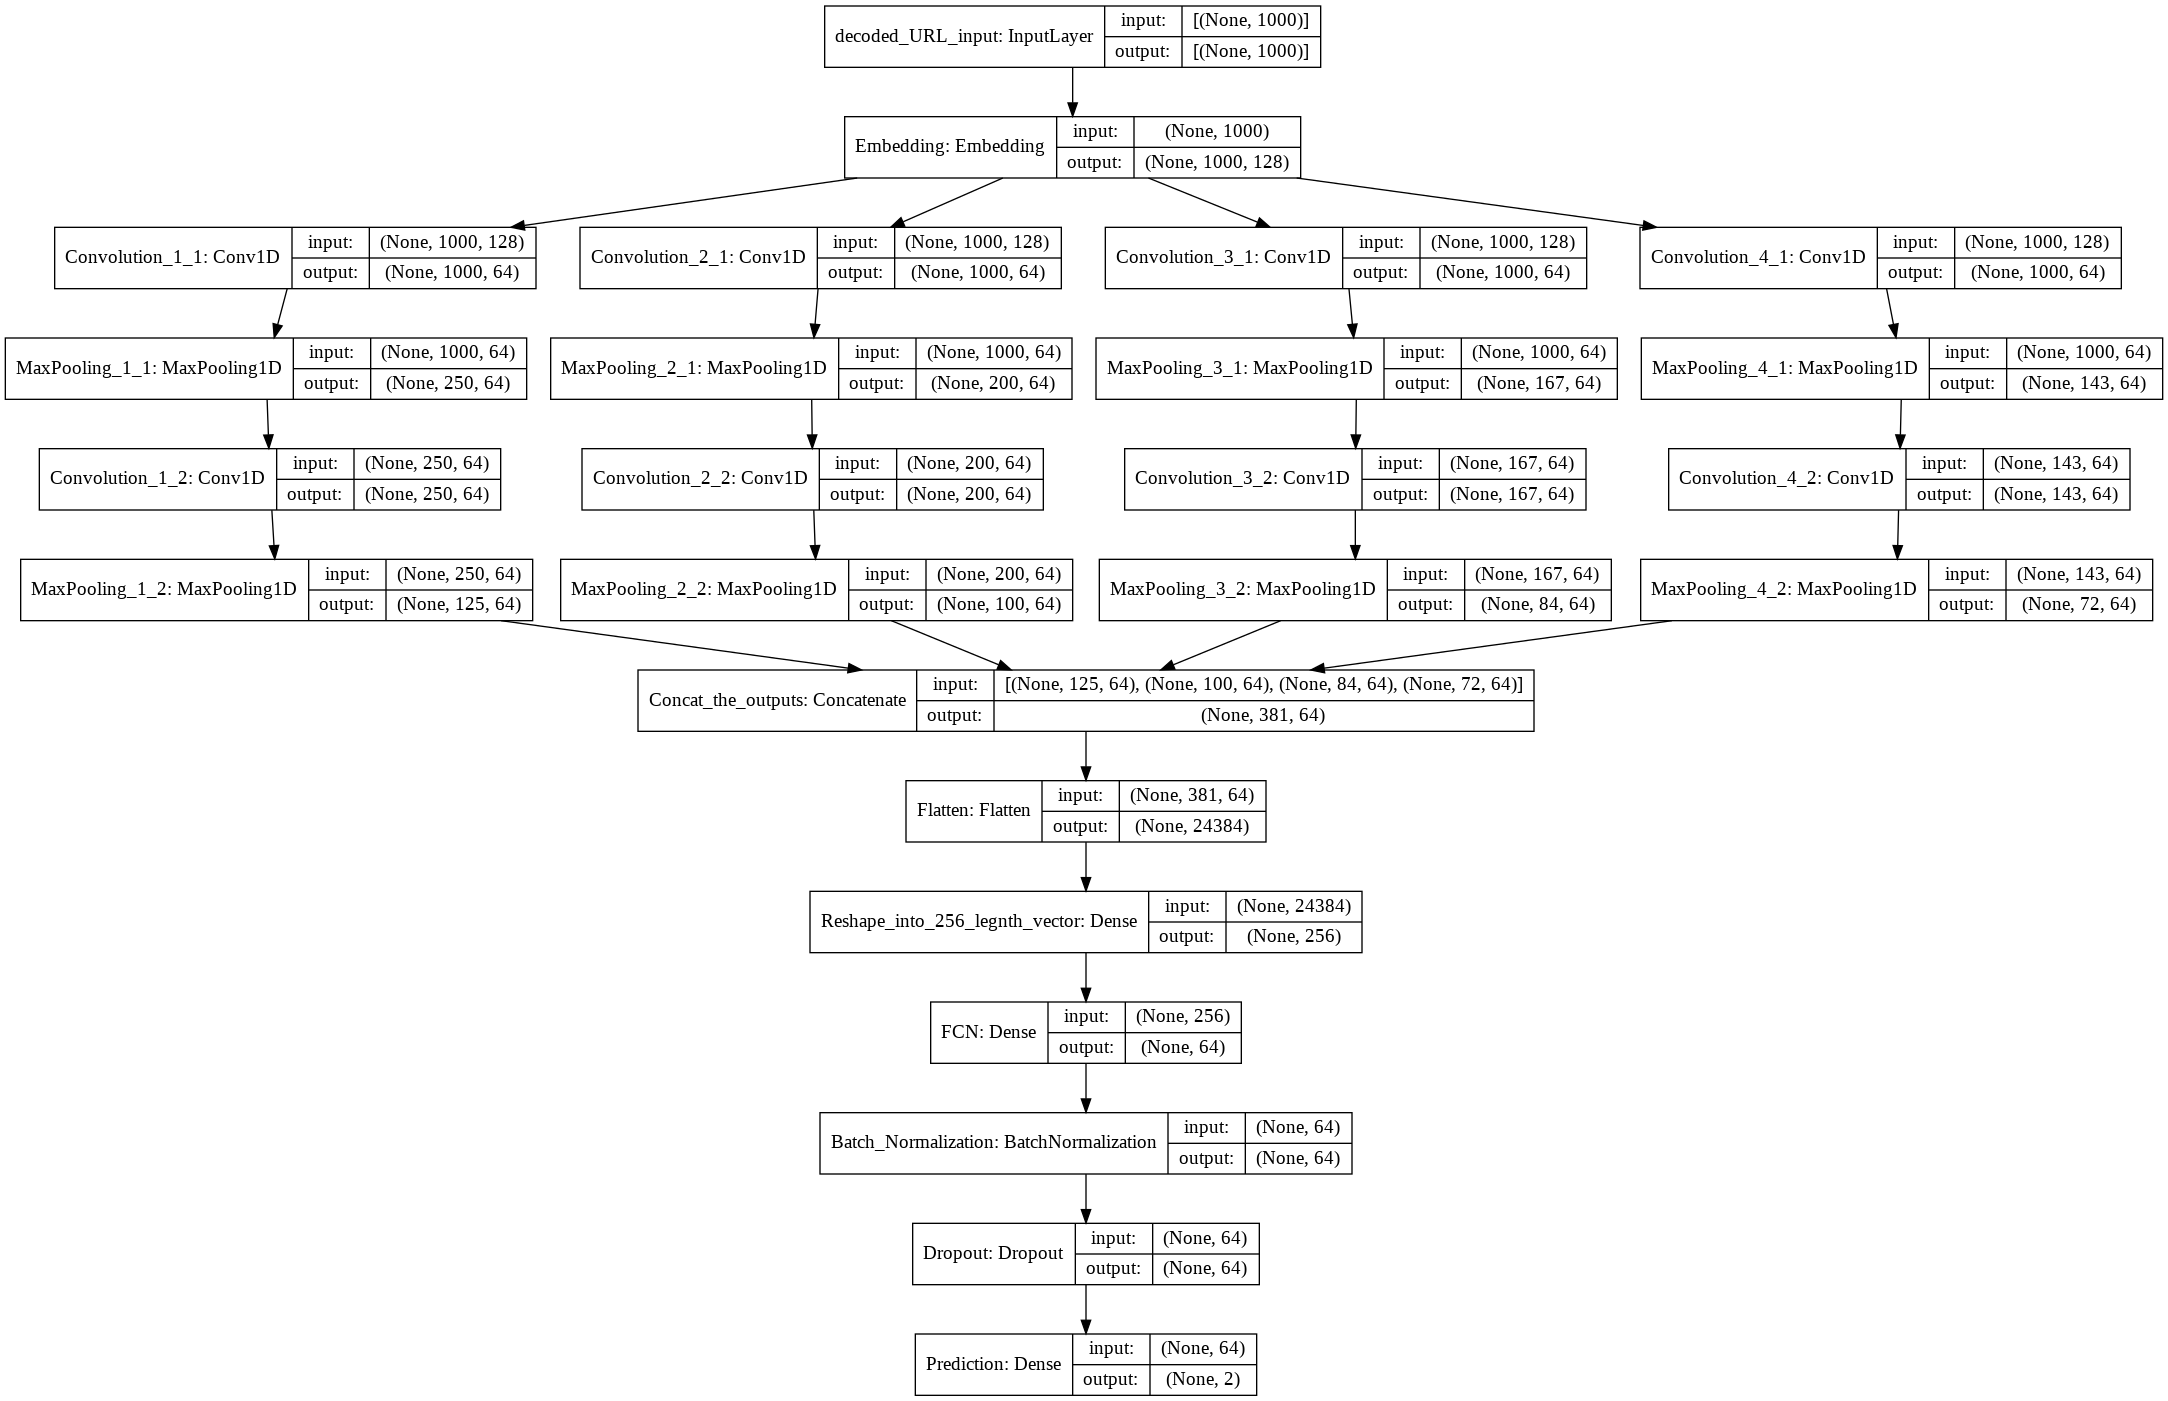

In [21]:
# Input Layer
# URLdecodeされた文字列をInputとして与える。
inputs = Input(shape=(input_max_size,), name='decoded_URL_input', dtype='int64')

# Embedding Layer
x = Embedding(input_max_size +1, embedding_size, input_length=input_max_size, mask_zero=True, name='Embedding')(inputs)
#x = Reshape((input_max_size, embedding_size), name='Reshape_into_128_legnth_vector')(x)

# Convolution Layers
convolution_output = []

conv1_1 = Conv1D(filter_num, 4, activation='relu', padding='same', name='Convolution_1_1')(x)
pool1_1 = MaxPool1D(pool_size=4, padding='same', name='MaxPooling_1_1')(conv1_1)
conv1_2 = Conv1D(filter_num,4, activation='relu', padding='same', name='Convolution_1_2')(pool1_1)
pool1_2 = MaxPool1D(padding='same', name='MaxPooling_1_2')(conv1_2)
convolution_output.append(pool1_2)

conv2_1 = Conv1D(filter_num,5, activation='relu', padding='same', name='Convolution_2_1')(x)
pool2_1 = MaxPool1D(pool_size=5, padding='same', name='MaxPooling_2_1')(conv2_1)
conv2_2 = Conv1D(filter_num,5, activation='relu', padding='same', name='Convolution_2_2')(pool2_1)
pool2_2 = MaxPool1D(padding='same', name='MaxPooling_2_2')(conv2_2)
convolution_output.append(pool2_2)

conv3_1 = Conv1D(filter_num, 6, activation='relu', padding='same', name='Convolution_3_1')(x)
pool3_1 = MaxPool1D(pool_size=6, padding='same', name='MaxPooling_3_1')(conv3_1)
conv3_2 = Conv1D(filter_num, 6, activation='relu', padding='same', name='Convolution_3_2')(pool3_1)
pool3_2 = MaxPool1D(padding='same', name='MaxPooling_3_2')(conv3_2)
convolution_output.append(pool3_2)

conv4_1 = Conv1D(filter_num,7, activation='relu', padding='same', name='Convolution_4_1')(x)
pool4_1 = MaxPool1D(pool_size=7, padding='same', name='MaxPooling_4_1')(conv4_1)
conv4_2 = Conv1D(filter_num, 7, activation='relu', padding='same', name='Convolution_4_2')(pool4_1)
pool4_2 = MaxPool1D(padding='same', name='MaxPooling_4_2')(conv4_2)
convolution_output.append(pool4_2)

# concat output
x = Concatenate(axis=-2, name='Concat_the_outputs')(convolution_output)

# reshape into 256 length vector
x = Flatten(name='Flatten')(x)
x = Dense(256, name='Reshape_into_256_legnth_vector')(x)

# Fully Connected Layers
# x = Flatten()(x)
x = Dense(64, activation='relu', name='FCN')(x)

# Batch Normalization
x = normalization.BatchNormalization(name='Batch_Normalization')(x)

# DropOut
x = Dropout(dropout, name='Dropout')(x)

# Fully Connected Layers
predictions = Dense(2, activation='softmax', name='Prediction')(x)

model = Model(inputs=inputs, outputs=predictions, name='Character-level_CNN')
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [22]:
model.summary()

Model: "Character-level_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoded_URL_input (InputLayer)  [(None, 1000)]       0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1000, 128)    128128      decoded_URL_input[0][0]          
__________________________________________________________________________________________________
Convolution_1_1 (Conv1D)        (None, 1000, 64)     32832       Embedding[0][0]                  
__________________________________________________________________________________________________
Convolution_2_1 (Conv1D)        (None, 1000, 64)     41024       Embedding[0][0]                  
________________________________________________________________________________

In [23]:
#Model = create_model(input_max_size, embedding_size, filter_num, fully_connected_layers)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [26]:
epochs = 100
batch_size = 128

In [27]:
# Training
model.fit(X_train_data, y_train_classes, validation_data=(X_test_data, y_test_classes), batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/100
382/382 - 37s - loss: 0.2231 - accuracy: 0.8613 - val_loss: 0.2561 - val_accuracy: 0.8290
Epoch 2/100
382/382 - 38s - loss: 0.2225 - accuracy: 0.8595 - val_loss: 0.5408 - val_accuracy: 0.8424
Epoch 3/100
382/382 - 38s - loss: 0.2196 - accuracy: 0.8613 - val_loss: 0.2582 - val_accuracy: 0.8570
Epoch 4/100
382/382 - 38s - loss: 0.2208 - accuracy: 0.8596 - val_loss: 0.2545 - val_accuracy: 0.8545
Epoch 5/100
382/382 - 38s - loss: 0.2229 - accuracy: 0.8572 - val_loss: 0.9401 - val_accuracy: 0.8291
Epoch 6/100
382/382 - 38s - loss: 0.2225 - accuracy: 0.8589 - val_loss: 0.6079 - val_accuracy: 0.8397
Epoch 7/100
382/382 - 38s - loss: 0.2217 - accuracy: 0.8596 - val_loss: 0.6540 - val_accuracy: 0.8374
Epoch 8/100
382/382 - 38s - loss: 0.2208 - accuracy: 0.8573 - val_loss: 0.5365 - val_accuracy: 0.8507
Epoch 9/100
382/382 - 38s - loss: 0.2225 - accuracy: 0.8609 - val_loss: 0.3787 - val_accuracy: 0.8156
Epoch 10/100
382/382 - 38s - loss: 0.2192 - accuracy: 0.8598 - val_loss: 0.2943 - 

In [28]:
model_filepath = 'model_dir/baseline'

model.save(model_filepath + '.h5')
model.save_weights(model_filepath + "_weight.h5")